# Results

Within this notebook, we load the results, and create the tables and plots for the paper. 

In [1]:
# we run the notebook in the root folder of the repo
%cd ..

/home/sherbold/git/sortbench


/home/sherbold/git/sortbench/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(df_results, mode, metric_name, file=None):
    if mode == 'basic':
        type_names = ['Int-0:1000', 'Float-0:1000', 'English']
        
        _, axes = plt.subplots(2, 2, figsize=(6, 5))
        for i, type in enumerate(type_names):
            row = i%2
            col = i//2
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', style='Model', errorbar=None, ax=ax)
            ax.set_title(type)
        plt.suptitle(metric_name)
        plt.tight_layout()
        axes[1,1].legend(*axes[1,0].get_legend_handles_labels(), loc='upper center')
        axes[1,1].axis('off')
        axes[0,0].legend().remove()
        axes[0,1].legend().remove()
        axes[1,0].legend().remove()
    elif mode == 'advanced':
        type_names = ['Integers-10000000:10001000',
                      'Int-n1000:1000',
                      'Float-10000000:10001000',
                      'Float-0:0.0001',
                      'Float-n1000-1000',
                      'ASCII-Lower',
                      'ASCII-Cased',
                      'PrfxEnglish',
                      'NumberWords']
        
        _, axes = plt.subplots(5, 2, figsize=(6, 10))
        for i, type in enumerate(type_names):
            row = i%5
            col = i//5
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', style='Model', errorbar=None, ax=ax)
            ax.set_title(type)
        plt.suptitle(metric_name)
        plt.tight_layout()
        axes[4,1].legend(*axes[4,0].get_legend_handles_labels(), loc='upper left')
        axes[4,1].axis('off')
        axes[0,0].legend().remove()
        axes[0,1].legend().remove()
        axes[1,0].legend().remove()
        axes[1,1].legend().remove()
        axes[2,0].legend().remove()
        axes[2,1].legend().remove()
        axes[3,0].legend().remove()
        axes[3,1].legend().remove()
        axes[4,0].legend().remove()
    elif mode == 'debug':
        type_names = ['Int-Sorted', 'Float-Sorted', 'English-Sorted', 'Int-Duplicate', 'Float-Duplicate', 'English-Duplicate']
        
        _, axes = plt.subplots(3, 2, figsize=(6, 7))
        for i, type in enumerate(type_names):
            row = i%3
            col = i//3
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', style='Model', errorbar=None, ax=ax)
            ax.set_title(type)
        plt.suptitle(metric_name)
        plt.tight_layout()
        axes[2,0].legend(ncol=2, loc='lower left', bbox_to_anchor=(0.3, -0.9))
        axes[0,0].legend().remove()
        axes[0,1].legend().remove()
        axes[1,0].legend().remove()
        axes[1,1].legend().remove()
        axes[2,1].legend().remove()

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

def plot_aggregated_results(df_results, mode, file=None):
    metrics = ['SortBench Score', 'Validity Score', 'Sorting Score', 'Faithfulness Score']
    _, axes = plt.subplots(2, 2, figsize=(9,6))
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        df_results_mode = df_results[df_results['Mode'] == mode]
        sns.lineplot(x='Size', y=metric, data=df_results_mode, hue='Model', style='Model', ax=ax, errorbar=None)
        ax.set_title(f"{metric} ({mode})")
    
    plt.tight_layout()
    axes[0,0].legend().remove()
    axes[0,1].legend().remove()
    axes[1,1].legend().remove()
    axes[1,0].legend(ncol=2, loc='lower left', bbox_to_anchor=(0.6, -0.6))
    
    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

def aggregate_scores(df_results, mode):
    df_results_mode = df_results[df_results['Mode'] == mode]
    df_results_mode = df_results_mode[['Model', 'Size', 'SortBench Score', 'Sorting Score', 'Faithfulness Score', 'Validity Score']]

    results_per_size = df_results_mode.groupby(['Model', 'Size'], observed=True).mean(numeric_only=True).reset_index()
    sum_of_sizes = results_per_size['Size'].unique().sum()
    results_per_size['Weighted SortBench Score'] = results_per_size['Size']*results_per_size['SortBench Score']
    results_per_size['Weighted Sorting Score'] = results_per_size['Size']*results_per_size['Sorting Score']
    results_per_size['Weighted Faithfulness Score'] = results_per_size['Size']*results_per_size['Faithfulness Score']
    results_per_size['Weighted Validity Score'] = results_per_size['Size']*results_per_size['Validity Score']
    results_per_model = results_per_size.groupby('Model', observed=True).sum(numeric_only=True)[['Weighted SortBench Score', 'Weighted Sorting Score', 'Weighted Faithfulness Score', 'Weighted Validity Score']]/sum_of_sizes
    results_per_model = pd.DataFrame(results_per_model).sort_values('Weighted SortBench Score', ascending=False).reset_index()
    return results_per_model

def create_latex_table(results_per_model, mode):
    latex_code = results_per_model.to_latex(index=False, float_format="%.3f")
    latex_code = latex_code.replace('Weighted ', '')
    rpl_string = r'\midrule\n\parbox[t]{2mm}{\multirow{6}{*}{\rotatebox[origin=c]{90}{'+mode.title()+r'}}}'
    latex_code = latex_code.replace(r'\midrule', rpl_string)
    return latex_code

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{6}{*}{\rotatebox[origin=c]{90}{Basic}}}
GPT-4o & 0.955 & 0.986 & 0.955 & 0.954 \\
GPT-4o-mini & 0.926 & 0.978 & 0.888 & 0.964 \\
Claude-3.5-Sonnet & 0.862 & 0.998 & 0.912 & 0.895 \\
Llama-3.1 & 0.833 & 0.989 & 0.709 & 0.832 \\
Claude-3.5-Haiku & 0.830 & 0.992 & 0.904 & 0.869 \\
DeepSeek-r1 & 0.658 & 0.823 & 0.694 & 0.677 \\
\bottomrule
\end{tabular}



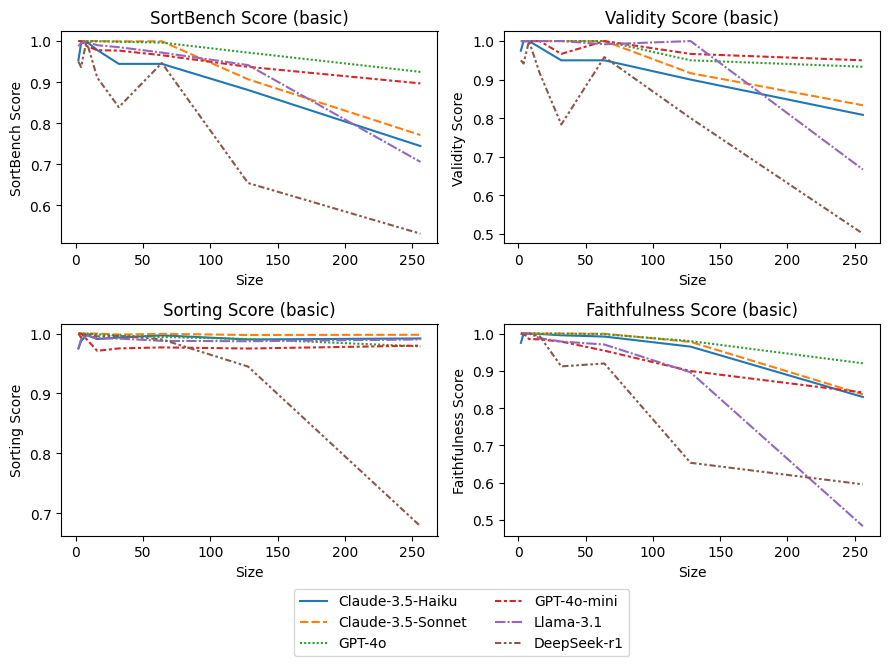

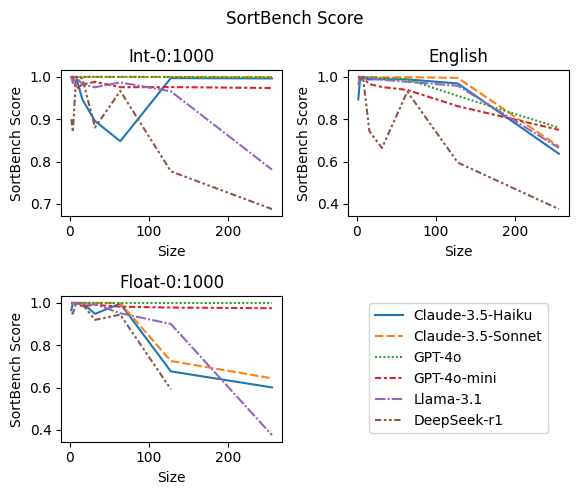

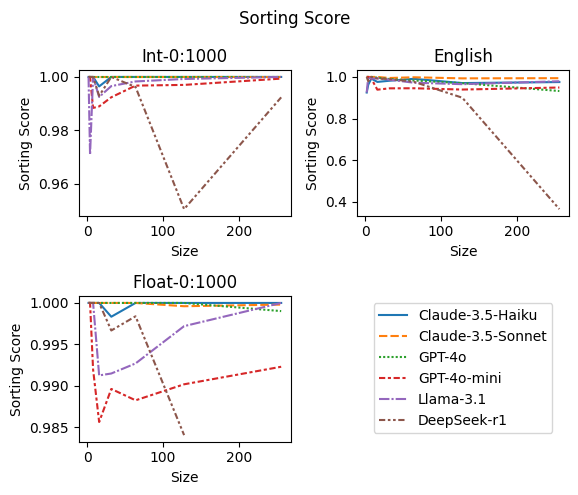

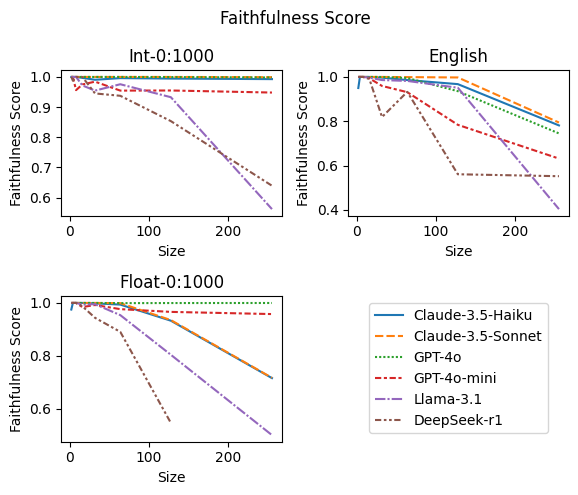

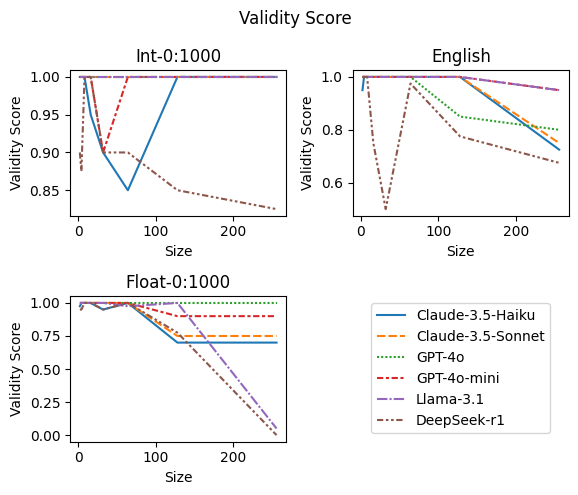

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{6}{*}{\rotatebox[origin=c]{90}{Advanced}}}
GPT-4o & 0.855 & 0.855 & 0.889 & 0.953 \\
Claude-3.5-Sonnet & 0.786 & 0.954 & 0.870 & 0.854 \\
Claude-3.5-Haiku & 0.764 & 0.930 & 0.850 & 0.852 \\
Llama-3.1 & 0.735 & 0.837 & 0.658 & 0.836 \\
GPT-4o-mini & 0.710 & 0.711 & 0.744 & 0.945 \\
DeepSeek-r1 & 0.629 & 0.951 & 0.614 & 0.593 \\
\bottomrule
\end{tabular}



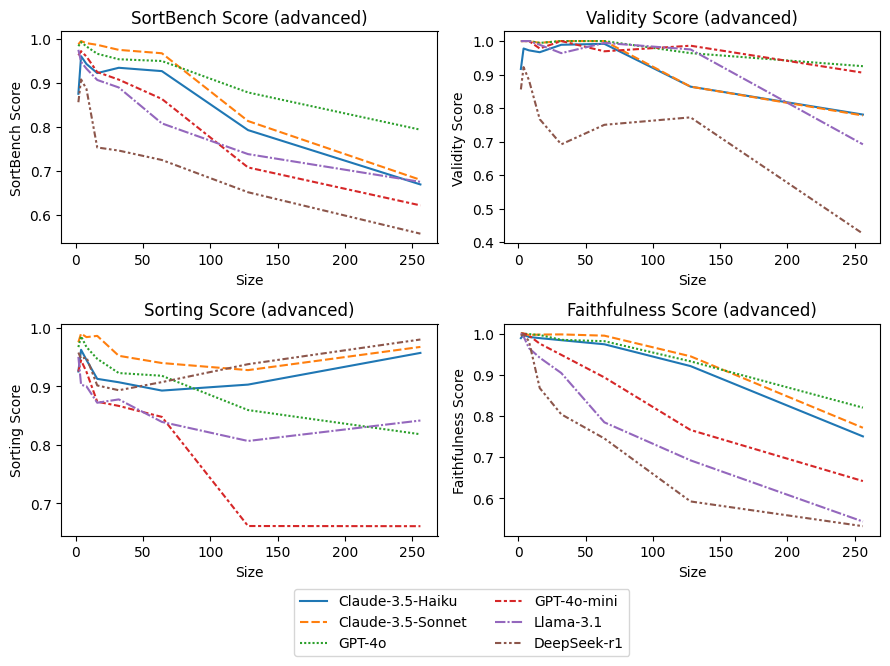

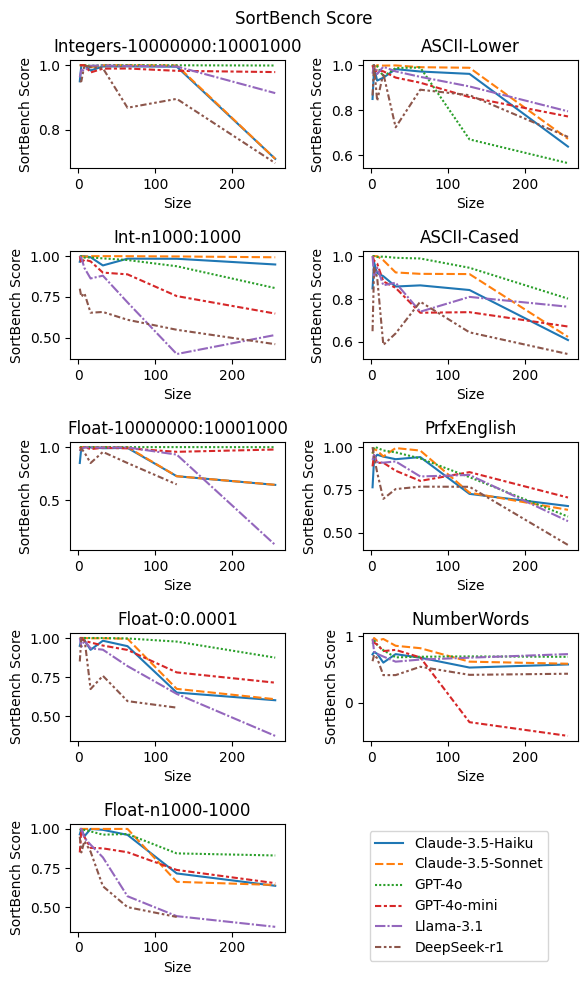

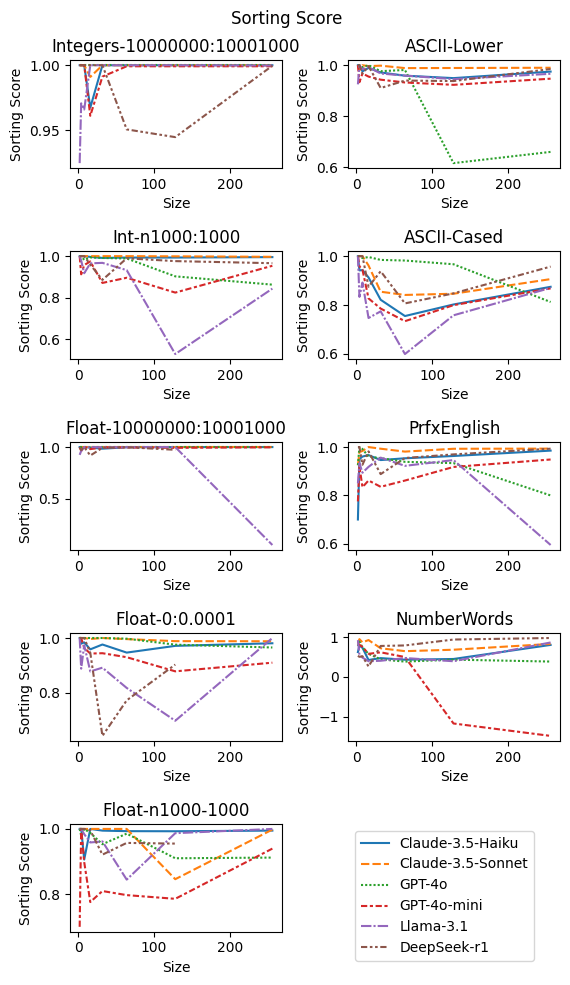

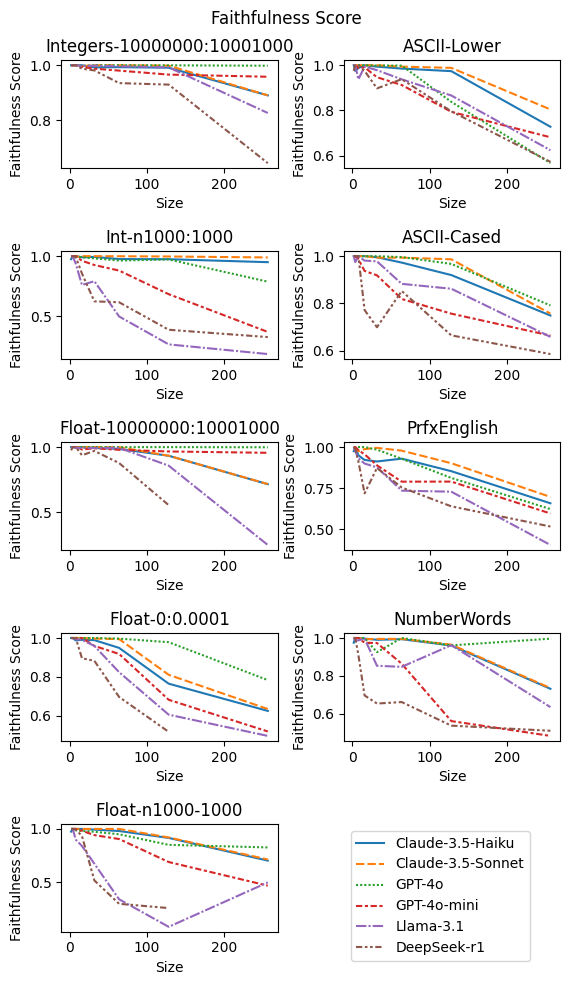

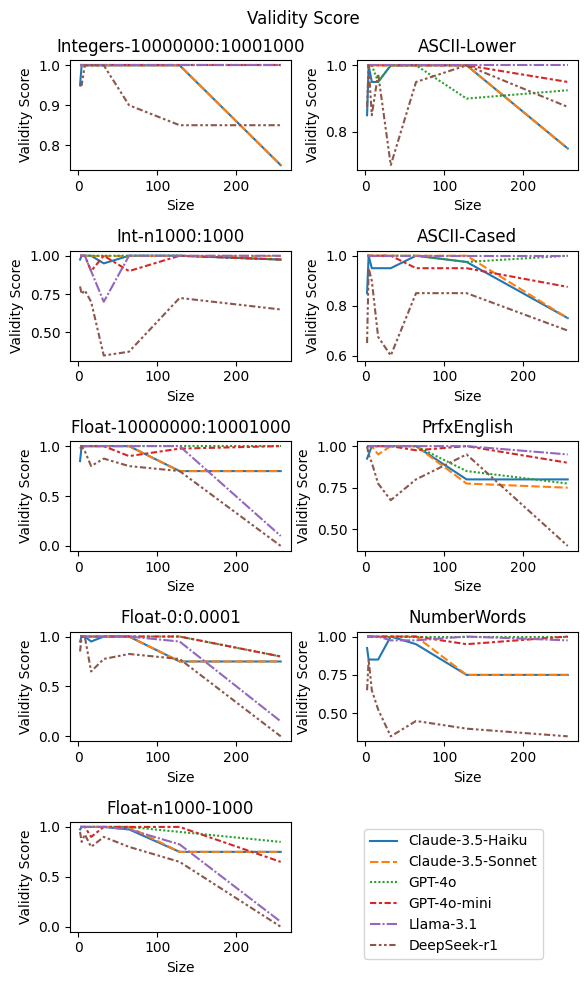

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{6}{*}{\rotatebox[origin=c]{90}{Debug}}}
GPT-4o & 0.998 & 0.998 & 0.998 & 1.000 \\
GPT-4o-mini & 0.945 & 0.990 & 0.905 & 0.990 \\
Llama-3.1 & 0.866 & 0.980 & 0.803 & 0.858 \\
Claude-3.5-Sonnet & 0.863 & 1.000 & 0.913 & 0.895 \\
Claude-3.5-Haiku & 0.844 & 0.998 & 0.898 & 0.886 \\
DeepSeek-r1 & 0.758 & 0.991 & 0.756 & 0.684 \\
\bottomrule
\end{tabular}



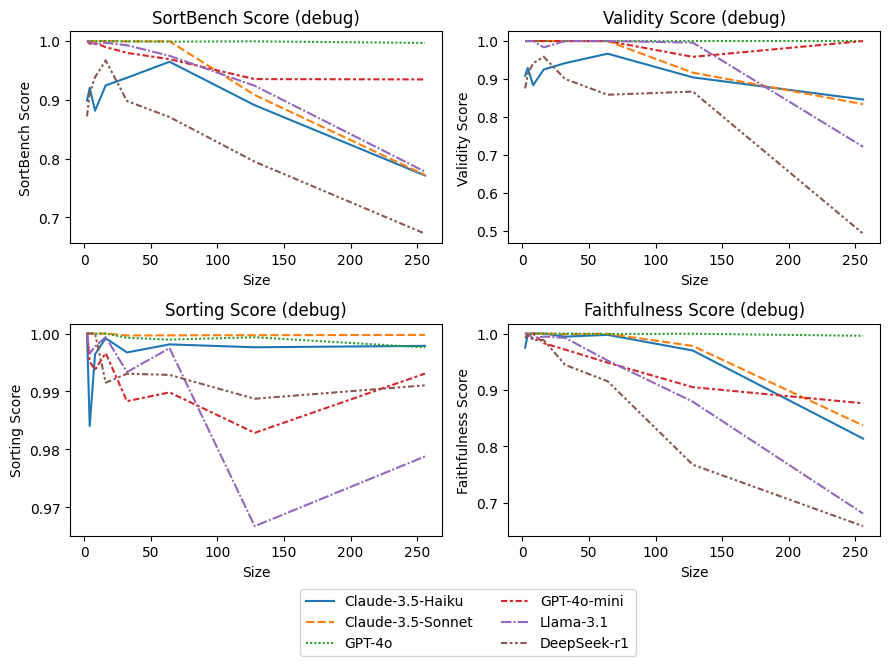

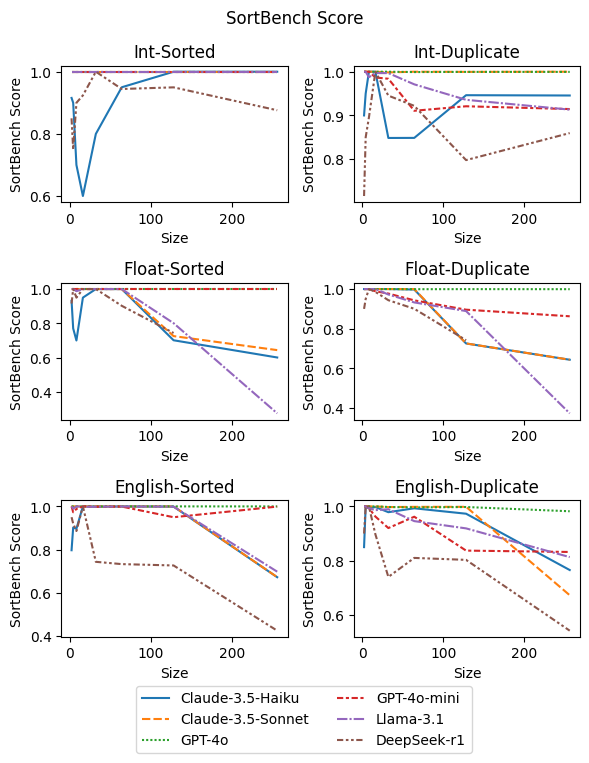

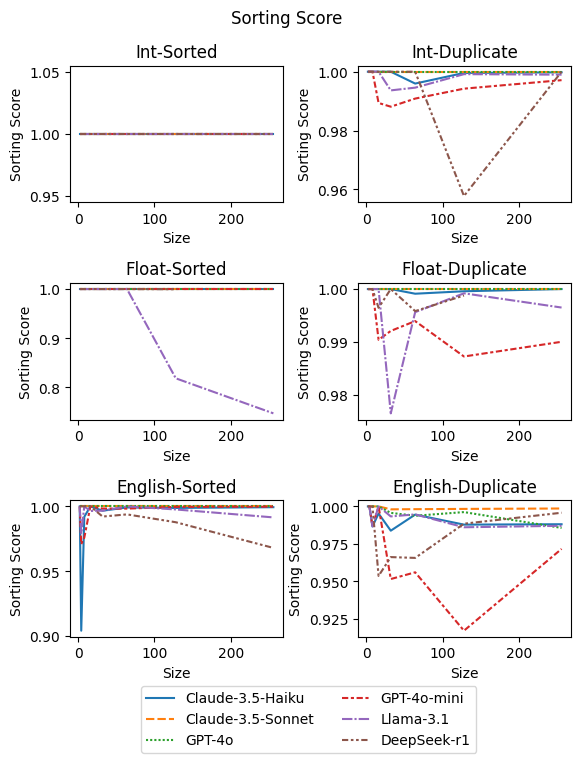

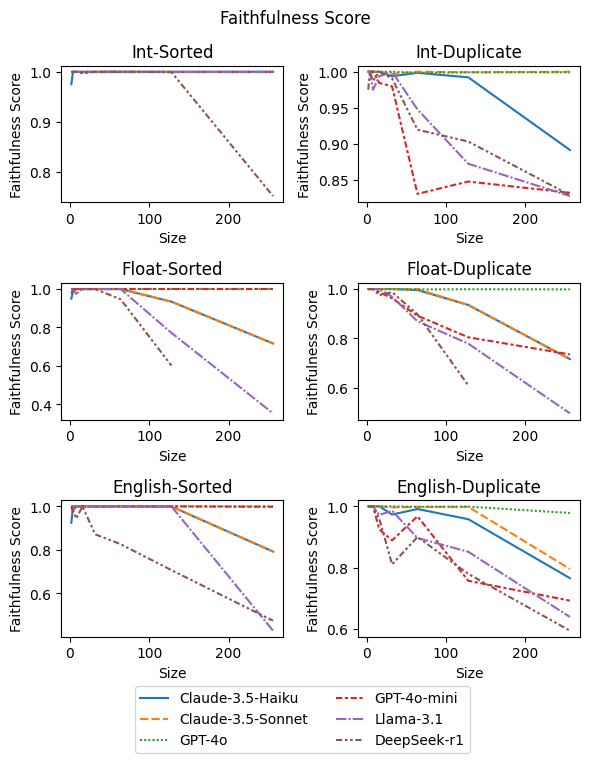

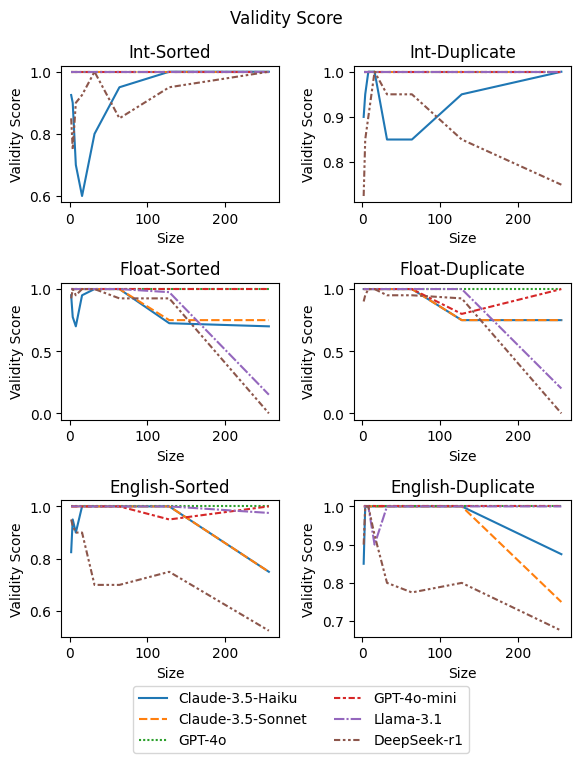

In [7]:
benchmark_modes = ['basic', 'advanced', 'debug'] # TODO add other modes later
#benchmark_modes = ['basic'] # TODO add other modes later
#benchmark_modes = ['advanced'] # TODO add other modes later
#benchmark_modes = ['debug'] # TODO add other modes later
version = "v1.0"

for mode in benchmark_modes:
    df_results = pd.read_csv(f'scores/scores_{mode}_{version}.csv')
    
    df_results.replace({'Model', 'gpt-4o'}, 'GPT-4o', inplace=True)
    df_results.replace({'Model', 'gpt-4o-mini'}, 'GPT-4o-mini', inplace=True)
    df_results.replace({'Model', 'claude-3-5-haiku-20241022'}, 'Claude-3.5-Haiku', inplace=True)
    df_results.replace({'Model', 'claude-3-5-sonnet-20241022'}, 'Claude-3.5-Sonnet', inplace=True)
    df_results.replace({'Model', 'llama3.1'}, 'Llama-3.1', inplace=True)
    df_results.replace({'Model', 'deepseekr1'}, 'DeepSeek-r1', inplace=True)
    df_results['Model'] = pd.Categorical(df_results['Model'], ['Claude-3.5-Haiku', 'Claude-3.5-Sonnet', 'GPT-4o', 'GPT-4o-mini', 'Llama-3.1', 'DeepSeek-r1'])
    results_per_model = aggregate_scores(df_results, mode)
    print(create_latex_table(results_per_model, mode))
    plot_aggregated_results(df_results, mode, file=f'figures/{mode}_aggregated_results.pdf')
    plot_metrics(df_results, mode, 'SortBench Score', file=f'figures/{mode}_sortbench_score.pdf')
    plot_metrics(df_results, mode, 'Sorting Score', file=f'figures/{mode}_sorting_score.pdf')
    plot_metrics(df_results, mode, 'Faithfulness Score', file=f'figures/{mode}_faithfulness_score.pdf')
    plot_metrics(df_results, mode, 'Validity Score', file=f'figures/{mode}_validity_score.pdf')


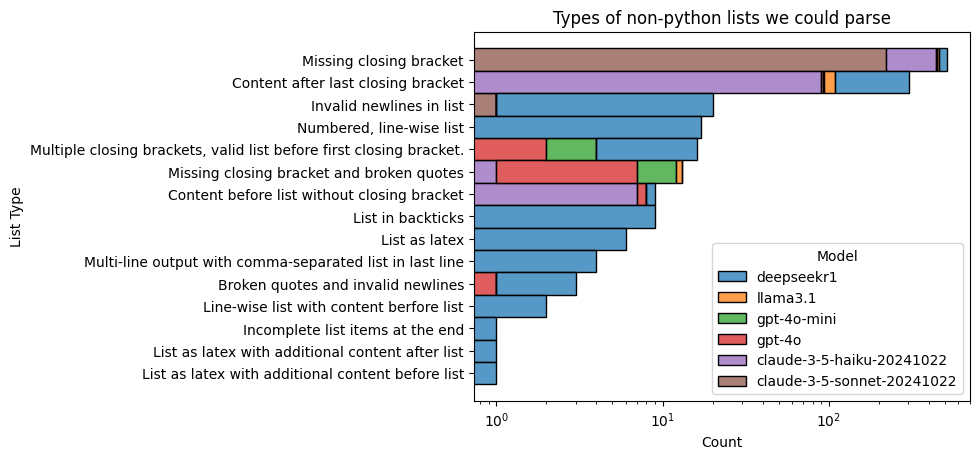

In [5]:
benchmark_modes = ['basic', 'advanced', 'debug']
version = "v1.0"
df_results_all = None
for mode in benchmark_modes:
    if df_results_all is None:
        df_results_all = pd.read_csv(f'scores/scores_{mode}_{version}.csv')
    else:
        df_results_all = pd.concat([df_results_all, pd.read_csv(f'scores/scores_{mode}_{version}.csv')], ignore_index=True)

error_order = df_results_all.groupby(['ErrorType']).count()['Model'].sort_values(ascending=False).index.tolist()
df_results_all['ErrorType'] = pd.Categorical(df_results_all['ErrorType'], error_order)
sns.histplot(df_results_all, y='ErrorType', hue='Model', multiple='stack')
plt.xscale('log')
plt.title('Types of non-python lists we could parse')
plt.ylabel('List Type')
plt.savefig('figures/error_types.pdf', bbox_inches='tight')
plt.show()